# Object Detection Module 

In [4]:
label_map = {
    1: "top", 
    2: "bottom", 
    3: "dress"
}

In [9]:
from detector import DetectorTF2 

detector = DetectorTF2(
    "../trained_model/frozen_model_1/saved_model/", 
    labelmap= label_map,
    threshold=0.50
)

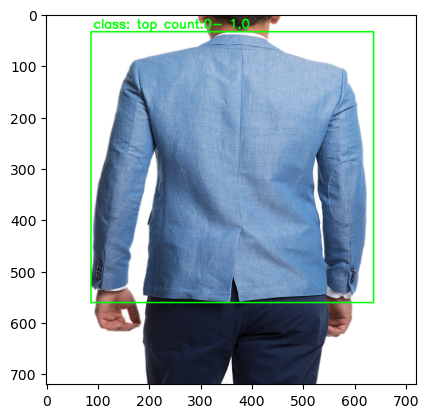

In [10]:
import matplotlib.pyplot as plt 
import cv2 

img = cv2.imread("../data/IMG_all/train/CEKET/6.png")

det_boxes = detector.DetectFromImage(img)
detected_img = detector.DisplayDetections(img, det_boxes) 

plt.imshow(cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGBA))
plt.show() 

In [11]:
detected_img.shape 

(720, 720, 3)

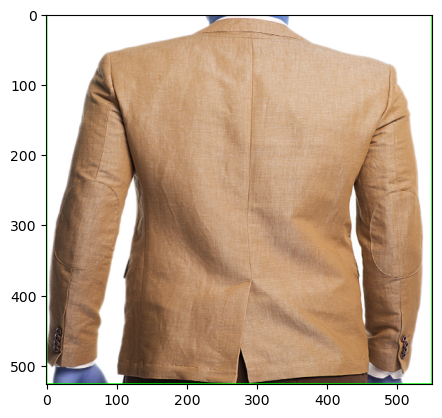

In [12]:
cropped_img = detected_img[det_boxes[0][1]: det_boxes[0][3], det_boxes[0][0]: det_boxes[0][2]] 
plt.imshow(cropped_img)
plt.show() 

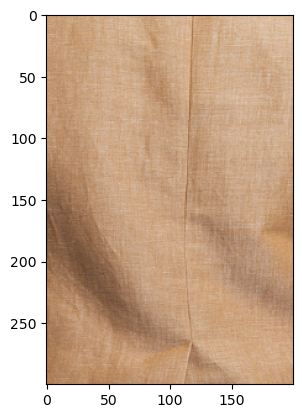

In [13]:
cw = 200 
ch = 300
center = cropped_img.shape
x = center[1]/2 - cw/2
y = center[0]/2 - ch/2
center_cropped = cropped_img[int(y):int(y+ch), int(x):int(x+cw)] 
plt.imshow(center_cropped) 
plt.show() 

# Color-Thief 

In [ ]:
from colorthief import ColorThief 

def crop_image(img_path:str, detector: DetectorTF2, sample_wh = (200, 200)): 
    img = cv2.imread(img_path)
    det_boxes = detector.DetectFromImage(img)
    img = img[det_boxes[0][1]: det_boxes[0][3], det_boxes[0][0]: det_boxes[0][2]] # cropped image 
    
    cw = sample_wh[0] 
    ch = sample_wh[1] 
    center = img.shape
    x = center[1]/2 - cw/2
    y = center[0]/2 - ch/2
    img = img[int(y):int(y+ch), int(x):int(x+cw)] 
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    return img

In [29]:
def zoom_at(img, zoom, coord=None):
    """
    Simple image zooming without boundary checking.
    Centered at "coord", if given, else the image center.

    img: numpy.ndarray of shape (h,w,:)
    zoom: float
    coord: (float, float)
    """
    # Translate to zoomed coordinates
    h, w, _ = [ zoom * i for i in img.shape ]
    
    if coord is None: cx, cy = w/2, h/2
    else: cx, cy = [ zoom*c for c in coord ]
    
    img = cv2.resize(img, (0, 0), fx=zoom, fy=zoom)
    img = img[ int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
               int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5)),
               : ]
    
    return img

In [14]:
import io 

def get_dominant_from_image(img_path:str, detector: DetectorTF2,zoom_rate ,sample_wh = (200, 200), n_palette=3): 
    img = cv2.imread(img_path)
    det_boxes = detector.DetectFromImage(img)
    img = img[det_boxes[0][1]: det_boxes[0][3], det_boxes[0][0]: det_boxes[0][2]] # cropped image 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # cw = sample_wh[0] 
    # ch = sample_wh[1] 
    # center = img.shape
    # x = center[1]/2 - cw/2
    # y = center[0]/2 - ch/2
    detected_img = img
    # img = img[int(y):int(y+ch), int(x):int(x+cw)] 
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    img = zoom_at(img, zoom_rate)

    # get dominant color 
    byteImgIO = io.BytesIO()
    byteImg = Image.fromarray(img)
    byteImg.save(byteImgIO, "PNG")
    byteImgIO.seek(0)
    byteImg = byteImgIO.read() 
    dataBytesIO = io.BytesIO(byteImg)
    ct = ColorThief(dataBytesIO) 
    
    dominant_color = ct.get_color(quality=1) 
    palette = ct.get_palette(color_count=n_palette, quality=1)  

    return img, detected_img, dominant_color, palette

In [ ]:
plt.imshow(crop_image("../data/IMG_all/train/CEKET/6.png", detector)) 
plt.show() 

In [ ]:
plt.imshow(crop_image("../data/IMG_all/train/dis-giyim/9.png", detector, sample_wh=(200, 200))) 
plt.show() 

# Clustering Method 

In [17]:
import cv2
import numpy as np

img = cv2.imread('../data/IMG_all/demo/manolya_kadin.png')
height, width, _ = np.shape(img)

data = np.reshape(img, (height * width, 3))
data = np.float32(data)

number_clusters = 2
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels, centers = cv2.kmeans(data, number_clusters, None, criteria, 10, flags)

compactness, centers

(1121829781.4031746,
 array([[233.14333, 233.93411, 246.58176],
        [105.26284, 137.79655, 189.83284]], dtype=float32))

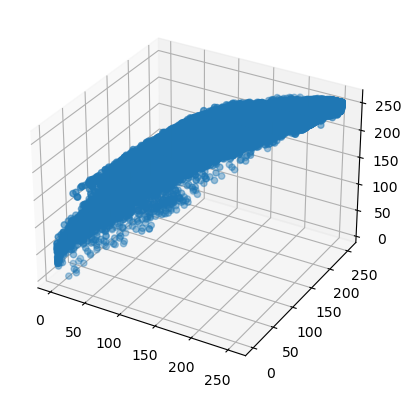

In [18]:
import pandas as pd 

dt = pd.DataFrame(data)
fig = plt.figure()
ax = fig.add_subplot(projection='3d') 
ax.scatter(dt.iloc[:, 0], dt.iloc[:, 1], dt.iloc[:, 2])

### K-Means Elbow 

In [19]:
from sklearn.cluster import KMeans

img = cv2.imread('../data/IMG_all/demo/manolya_kadin.png')
height, width, _ = np.shape(img)

data = np.reshape(img, (height * width, 3))
data = np.float32(data)

costs = [] 
K = np.array(range(1,10))
for k in K:    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness, labels, centers = cv2.kmeans(data, k, None, criteria, 10, flags) 
    costs.append(compactness)


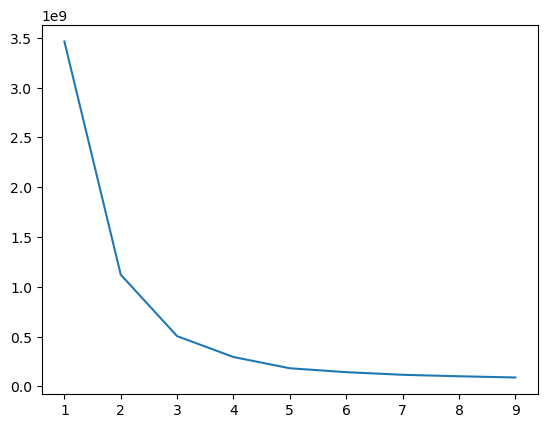

In [20]:
plt.plot(K, costs)
plt.show() 

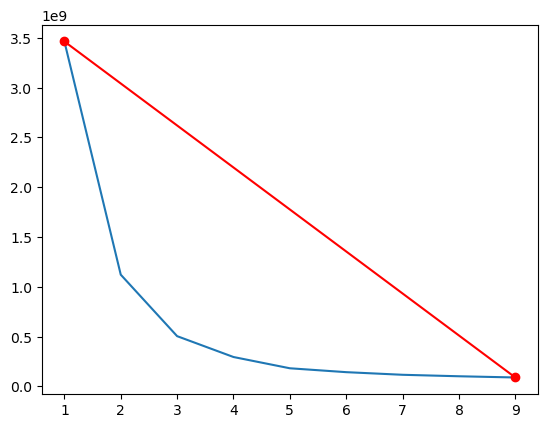

In [21]:
plt.plot(K, costs)
costs = np.array(costs)
plt.plot([K[0], K[-1]], [costs[0], costs[-1]], 'ro-')
plt.show() 

In [22]:
import math
def distance_from_line(x1, y1, a, b, c): 
    d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
    return d 

In [23]:
a = costs[0] - costs[-1] 
b = K[-1] - K[0] 
c1 = K[0] * costs[-1] 
c2 = K[-1] * costs[0] 
c = c1 - c2   
# line denklemö

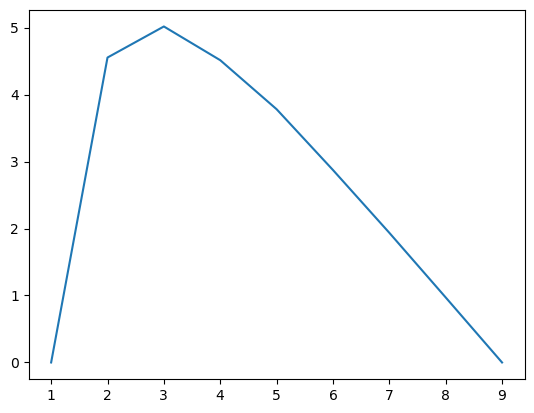

In [24]:
distances_fron_line = [] 
for k in range(len(K)): 
    distances_fron_line.append(distance_from_line(K[k], costs[k], a, b, c)) 

plt.plot(K, distances_fron_line) 

In [25]:
K[distances_fron_line.index(max(distances_fron_line))]

3

In [26]:
def get_dominant_from_image(img_path:str, detector: DetectorTF2, zoom_rate , sample_wh = (200, 200), n_palette=3): 
    img = cv2.imread(img_path)
    det_boxes = detector.DetectFromImage(img)
    img = img[det_boxes[0][1]: det_boxes[0][3], det_boxes[0][0]: det_boxes[0][2]] # cropped image 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # cw = sample_wh[0] 
    # ch = sample_wh[1] 
    # center = img.shape
    # x = center[1]/2 - cw/2
    # y = center[0]/2 - ch/2
    detected_img = img
    # img = img[int(y):int(y+ch), int(x):int(x+cw)] 
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    img = zoom_at(img, zoom_rate)

    # get dominant color 
    height, width, _ = np.shape(img)
    data = np.reshape(img, (height * width, 3))
    data = np.float32(data)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness, labels, centers = cv2.kmeans(data, n_palette, None, criteria, 10, flags)
    
    return img, detected_img, centers.astype(np.int16) 

In [27]:
def get_dominant_from_image_autoK(img_path:str, detector: DetectorTF2, zoom_rate, K = range(1,6)): 
    img = cv2.imread(img_path)
    det_boxes = detector.DetectFromImage(img)
    img = img[det_boxes[0][1]: det_boxes[0][3], det_boxes[0][0]: det_boxes[0][2]] # cropped image 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    detected_img = img
    img = zoom_at(img, zoom_rate)

    # get dominant color 
    height, width, _ = np.shape(img)
    data = np.reshape(img, (height * width, 3))
    data = np.float32(data)
    
    costs = [] 
    centerss = [] 
    K = np.array(range(1,6))
    for k in K:    
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        flags = cv2.KMEANS_RANDOM_CENTERS
        compactness, labels, centers = cv2.kmeans(data, k, None, criteria, 10, flags) 
        costs.append(compactness)
        centerss.append(centers)
    
    costs = np.array(costs)
    a = costs[0] - costs[-1] 
    b = K[-1] - K[0] 
    c1 = K[0] * costs[-1] 
    c2 = K[-1] * costs[0] 
    c = c1 - c2 

    distances_from_line = [] 
    for k in range(len(K)): 
        distances_from_line.append(distance_from_line(K[k], costs[k], a, b, c)) 
    
    r = distances_fron_line.index(max(distances_fron_line))
    print(K[distances_fron_line.index(max(distances_fron_line))])
    
    return img, detected_img, centerss[r].astype(np.int16) 

In [30]:
img, detected_img, centers  = get_dominant_from_image("../data/IMG_all/demo/kiz_cocuk.png", detector, 2)

3


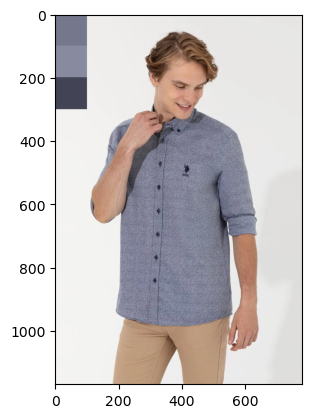

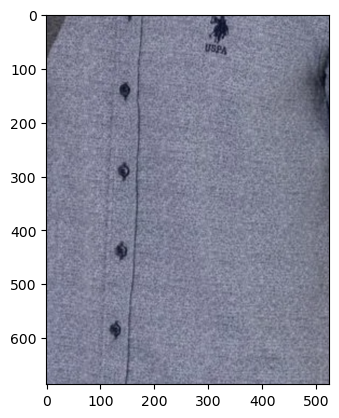

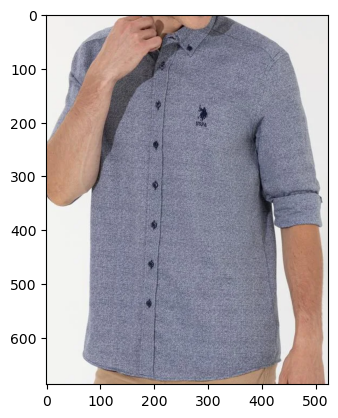

In [31]:
path = "../data/IMG_all/demo/lacivert_erkek_uzun.png"
img, detected_img, centers = get_dominant_from_image_autoK(path, detector=detector, zoom_rate=2, K=range(1, 4))
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
y_point = -100
for c in centers: 
    y_point += 100 
    image = cv2.rectangle(image, (0, y_point), (100, y_point + 100), color=(int(c[0]), int(c[1]),int(c[2])), thickness=-1) 


plt.imshow(image)
plt.show() 
plt.imshow(img)
plt.show() 
plt.imshow(detected_img)
plt.show() 

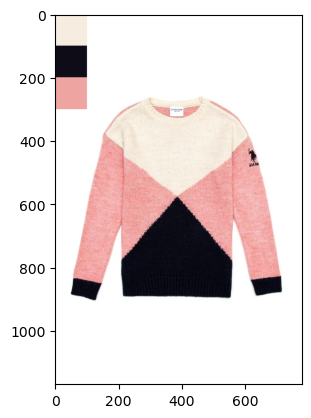

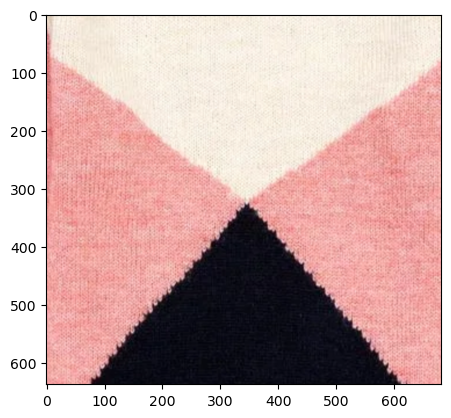

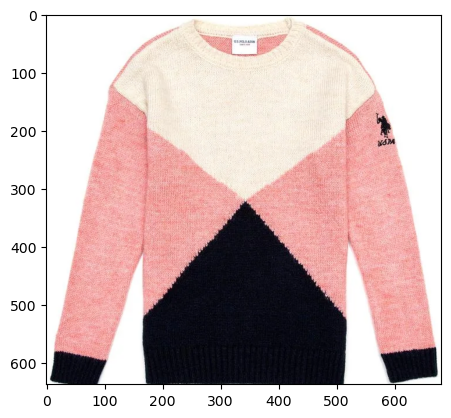

In [32]:
path = "../data/IMG_all/demo/kiz_cocuk.png"
img, detected_img, centers = get_dominant_from_image(path, detector=detector, zoom_rate=2, n_palette=3)
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
y_point = -100
for c in centers: 
    y_point += 100 
    cv = cv2.rectangle(image, (0, y_point), (100, y_point + 100), color=(int(c[0]), int(c[1]),int(c[2])), thickness=-1) 


plt.imshow(cv)
plt.show() 
plt.imshow(img)
plt.show() 
plt.imshow(detected_img)
plt.show() 

# K-Modes Clustering 

In [26]:
# !pip install kmodes

In [27]:
from kmodes.kmodes import KModes 
def get_dominant_from_image_kModes(img_path:str, detector: DetectorTF2, zoom_rate , sample_wh = (200, 200), n_palette=3): 
    img = cv2.imread(img_path)
    det_boxes = detector.DetectFromImage(img)
    img = img[det_boxes[0][1]: det_boxes[0][3], det_boxes[0][0]: det_boxes[0][2]] # cropped image 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # cw = sample_wh[0] 
    # ch = sample_wh[1] 
    # center = img.shape
    # x = center[1]/2 - cw/2
    # y = center[0]/2 - ch/2
    detected_img = img
    # img = img[int(y):int(y+ch), int(x):int(x+cw)] 
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    img = zoom_at(img, zoom_rate)

    # get dominant color 
    height, width, _ = np.shape(img)
    data = np.reshape(img, (height * width, 3))
    data = np.float32(data)
    model = KModes(n_clusters=n_palette, init="random", n_init=1, verbose=1) 
    model.fit_predict(data) 

    return img, detected_img, model.cluster_centroids_.astype(np.int16) 

In [28]:
# path = "../data/IMG_all/demo/kiz_cocuk.png"
# img, detected_img, centers = get_dominant_from_image_kModes(path, detector=detector, zoom_rate=2, sample_wh=(100, 200), n_palette=3)
# image = cv2.imread(path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
# y_point = 100
# for c in centers: 
#     y_point += 100 
#     cv = cv2.rectangle(image, (100, y_point), (200, y_point + 100), color=(int(c[0]), int(c[1]),int(c[2])), thickness=-1) 

# plt.imshow(cv)
# plt.show() 
# plt.imshow(img)
# plt.show() 
# plt.imshow(detected_img)
# plt.show() 

# Color Histograms 

In [29]:
def get_dominant_from_image(img_path:str, detector: DetectorTF2, zoom_rate , sample_wh = (200, 200), n_palette=3): 
    img = cv2.imread(img_path)
    det_boxes = detector.DetectFromImage(img)
    img = img[det_boxes[0][1]: det_boxes[0][3], det_boxes[0][0]: det_boxes[0][2]] # cropped image 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    detected_img = img
    img = zoom_at(img, zoom_rate)

    # get dominant color 
    height, width, _ = np.shape(img)
    data = np.reshape(img, (height * width, 3))
    data = np.float32(data)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness, labels, centers = cv2.kmeans(data, n_palette, None, criteria, 10, flags)
    
    return img, detected_img, centers.astype(np.int16) 

In [30]:
histogram = cv2.calcHist([img], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])

In [31]:
# Calculate the color histogram
histogram = cv2.calcHist([img], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])

# Set the threshold for selecting dominant colors
threshold = 1000

# Create an empty list to store the dominant colors
dominant_colors = []

# Iterate over the histogram bins and find dominant colors
for r in range(256):
    for g in range(256):
        for b in range(256):
            if histogram[r, g, b] > threshold:
                dominant_colors.append((r, g, b))

# Print the dominant colors in RGB format
for color in dominant_colors:
    print(f"RGB: {color}")

RGB: (8, 8, 19)
RGB: (9, 9, 20)
RGB: (9, 10, 19)
RGB: (9, 10, 21)
RGB: (10, 11, 20)
RGB: (10, 11, 22)
RGB: (11, 12, 21)
RGB: (11, 12, 23)
RGB: (12, 13, 22)
RGB: (12, 13, 24)
RGB: (13, 13, 24)
RGB: (13, 14, 25)
RGB: (14, 14, 25)
RGB: (244, 235, 222)
RGB: (245, 236, 223)
RGB: (246, 237, 224)
RGB: (247, 238, 225)
RGB: (248, 239, 226)
RGB: (249, 240, 227)
RGB: (250, 241, 228)


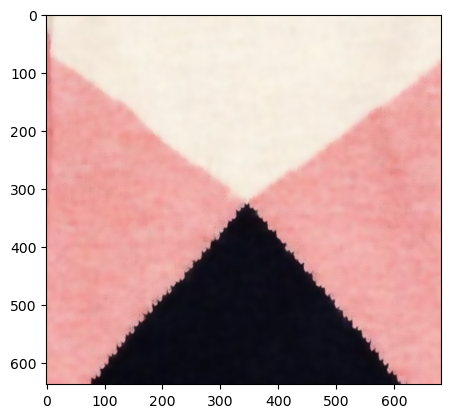

In [33]:
bilateral = cv2.bilateralFilter(img, 15, 75, 75)
plt.imshow(bilateral)

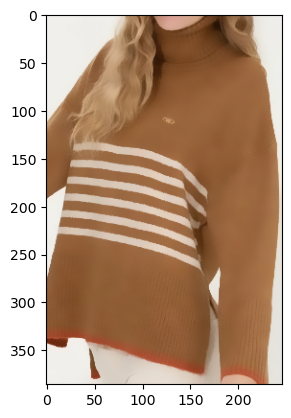

In [34]:
plt.imshow(cv2.bilateralFilter(cv2.cvtColor(cv2.imread("../data/IMG_all/demo/melanj_uspa.PNG"), cv2.COLOR_BGR2RGB), 15, 75, 75))

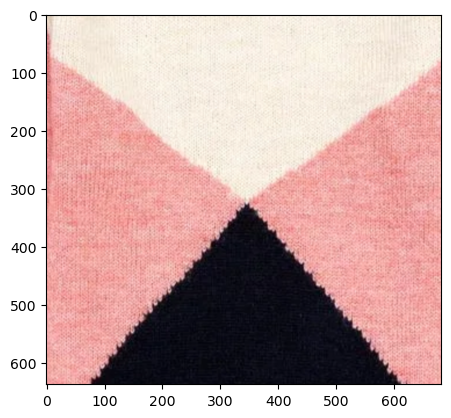

In [35]:
plt.imshow(img)

In [37]:
kernel = np.ones((5,5), np.uint8)

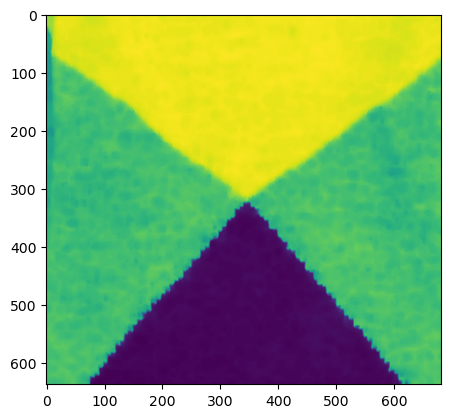

In [38]:
plt.imshow(cv2.erode(cv2.cvtColor(bilateral, cv2.COLOR_BGR2GRAY), kernel, iterations=1))

In [39]:
len(np.unique(img.reshape(-1, 3), axis=0, return_counts = False))

41983

In [39]:
bilateral
len(np.unique(bilateral.reshape(-1, 3), axis=0, return_counts = False))

21888

# Median-Cut Algorithm 

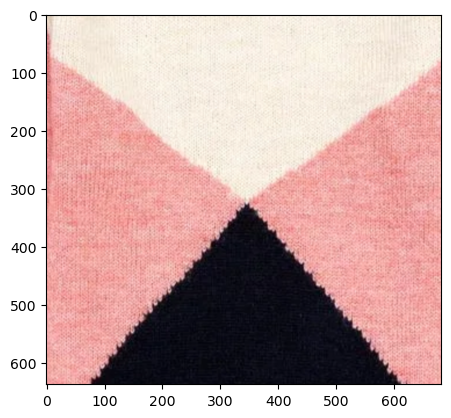

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

bilateral = cv2.bilateralFilter(img, 15, 75, 75)
sample_img =   img.copy() 

plt.imshow(sample_img)
plt.show()

In [41]:
def median_cut_quantize(img, img_arr):
    # when it reaches the end, color quantize
    print("start quantize: ", len(img_arr))
    r_average = np.mean(img_arr[:,0])
    g_average = np.mean(img_arr[:,1])
    b_average = np.mean(img_arr[:,2])
    
    for data in img_arr:
        sample_img[data[3]][data[4]] = [r_average, g_average, b_average]
    
def split_into_buckets(img, img_arr, depth):
    
    if len(img_arr) == 0:
        return 
        
    if depth == 0:
        median_cut_quantize(img, img_arr)
        return
    
    r_range = np.max(img_arr[:,0]) - np.min(img_arr[:,0])
    g_range = np.max(img_arr[:,1]) - np.min(img_arr[:,1])
    b_range = np.max(img_arr[:,2]) - np.min(img_arr[:,2])
    
    space_with_highest_range = 0

    if g_range >= r_range and g_range >= b_range:
        space_with_highest_range = 1
    elif b_range >= r_range and b_range >= g_range:
        space_with_highest_range = 2
    elif r_range >= b_range and r_range >= g_range:
        space_with_highest_range = 0

    print("space_with_highest_range:",space_with_highest_range)

    # sort the image pixels by color space with highest range 
    # and find the median and divide the array.
    img_arr = img_arr[img_arr[:,space_with_highest_range].argsort()]
    median_index = int((len(img_arr)+1)/2)
    print("median_index:", median_index)

    
    #split the array into two blocks
    split_into_buckets(img, img_arr[0:median_index], depth-1)
    split_into_buckets(img, img_arr[median_index:], depth-1)
    
flattened_img_array = []
for rindex, rows in enumerate(sample_img):
    for cindex, color in enumerate(rows):
        flattened_img_array.append([color[0],color[1],color[2],rindex, cindex]) 

flattened_img_array = np.array(flattened_img_array)
split_into_buckets(sample_img, flattened_img_array, 2)

space_with_highest_range: 0
median_index: 217558
space_with_highest_range: 1
median_index: 108779
start quantize:  108779
start quantize:  108779
space_with_highest_range: 1
median_index: 108779
start quantize:  108779
start quantize:  108779


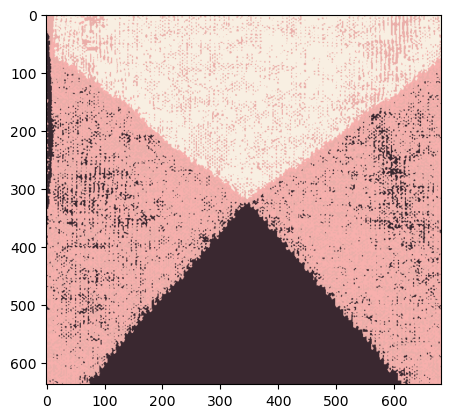

In [42]:
plt.imshow(sample_img) 
plt.show() 

In [43]:
len(np.unique(sample_img.reshape(-1, 3), axis=0, return_counts = False))

4

In [44]:
np.unique(sample_img.reshape(-1, 3),axis=0)

array([[ 58,  40,  48],
       [234, 174, 169],
       [247, 176, 173],
       [248, 239, 226]], dtype=uint8)

In [45]:
reshaped_sample = sample_img.reshape(-1, 3)

In [46]:
import collections 
d = dict(sorted(collections.Counter(map(tuple, reshaped_sample)).items(), key=lambda item: item[1]))

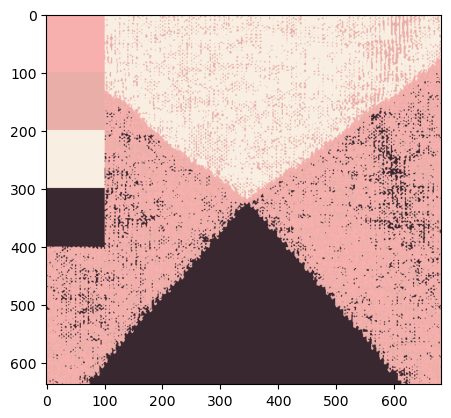

In [47]:
y_point = -100
for c in d.keys():
    y_point += 100 
    sample_img = cv2.rectangle(sample_img, (0, y_point), (100, y_point + 100), color=(int(c[0]), int(c[1]),int(c[2])), thickness=-1) 

plt.imshow(sample_img)
plt.show() 

# DBSCAN Algorithm 

In [48]:
img = cv2.imread('../data/IMG_all/demo/manolya_kadin.png')
height, width, _ = np.shape(img)

data = np.reshape(img, (height * width, 3))
data = np.float32(data)
data.shape 

(912600, 3)

In [ ]:
# from sklearn.cluster import DBSCAN
# clustering = DBSCAN(eps=0.5, min_samples=2).fit(data) 
# worst case O(n^2)

# Mean Shift Clustering 

In [51]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwith = estimate_bandwidth(data, quantile=0.3, n_samples=300) 
bandwith

32.07271424817379

In [52]:
ms = MeanShift(bandwidth=bandwith) 
# ms.fit(data)

# Feature Based Dom Color Extraction Method 

#### Path
1) Extract a greater number of candidate colors than the 100
final ones (Sec. III-B). 101
2) Calculate the saturation, area, and color contrast to the 102
surroundings of each candidate color (Sec. III-C). 103
3) Select the final dominant colors from the candidates 104
according to their color features (Sec. III-D).

In [103]:
from skimage import color 
import cv2
import numpy as np 
import pandas as pd 

img_inRGB = cv2.imread("../data/IMG_all/demo/renk_detay.png") # can be read by skimage.io.imread function. it accelerates 
img_inRGB = cv2.cvtColor(img_inRGB, cv2.COLOR_BGR2RGB)
img_inLAB = color.rgb2lab(img_inRGB)

## 1. plot in CIELAB

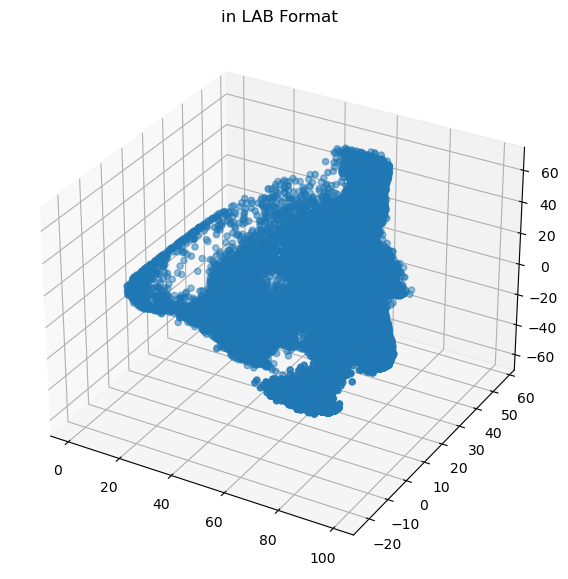

In [104]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

data = np.reshape(img_inLAB, (-1, 3))
dt = pd.DataFrame(data)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection='3d') 
ax.scatter(dt.iloc[:, 0], dt.iloc[:, 1], dt.iloc[:, 2])
plt.title("in LAB Format")
plt.show() 

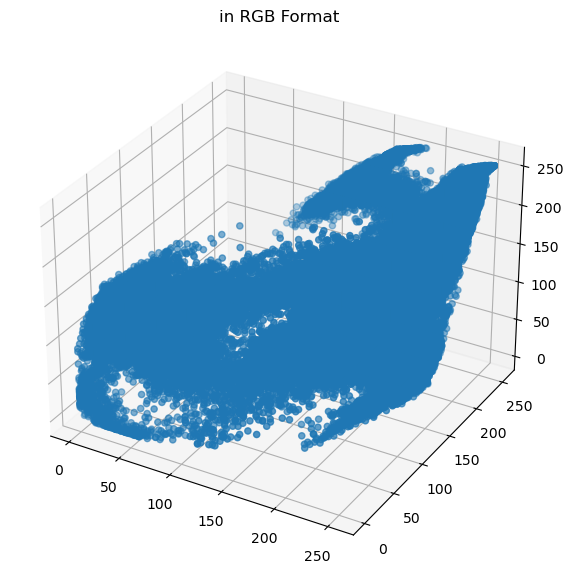

In [105]:
data = np.reshape(img_inRGB, (-1, 3))
dt = pd.DataFrame(data)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection='3d') 
ax.scatter(dt.iloc[:, 0], dt.iloc[:, 1], dt.iloc[:, 2])
plt.title("in RGB Format")
plt.show() 

## 2. Clustering (k=8) 

- (L*, a*, b*) CIELAB Color Space value definition 
The asterisk (*) symbol of L*, a* and b* indicates that this is the new color system; it is the follow-up of the older CIELAB system.  
The new system is now universally used for the quantification of colors, even though often the simplified notation of the Lab-values, without the * symbol, is used.

In [106]:
filtered_inRGB = cv2.bilateralFilter(img_inRGB, 15, 100, 100)
img_inLAB_original = color.rgb2lab(filtered_inRGB) 
img_inLAB = img_inLAB_original.reshape((img_inLAB.shape[0] * img_inLAB.shape[1], 3))
img_inLAB.shape 

(912600, 3)

In [107]:
number_clusters = 10 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels, centers = cv2.kmeans(np.float32(img_inLAB), number_clusters, None, criteria, 10, flags)

compactness, centers

(9576569.11628503,
 array([[ 67.95844  ,  31.914118 ,  41.770153 ],
        [ 68.18086  ,  38.473274 ,  55.08166  ],
        [ 22.838018 ,  25.414019 , -46.32852  ],
        [ 74.243515 ,  18.669287 ,  23.947145 ],
        [ 86.79756  ,   8.228873 ,   1.7837074],
        [ 53.24915  ,  43.59136  ,   5.679507 ],
        [ 58.156445 ,  49.41824  , -20.74583  ],
        [ 23.19209  ,  24.842571 , -30.76233  ],
        [ 82.78324  , -16.656115 , -14.066635 ],
        [ 93.462135 ,   2.0131338,  -5.029306 ]], dtype=float32))

In [108]:
min(img_inLAB.flatten())

-55.66411113571539

### Convert LAB color to RGB Color 

In [109]:
# !pip install colormath

In [110]:
from colormath.color_objects import LabColor, sRGBColor 
from colormath.color_conversions import convert_color

lab = LabColor(66.097176 ,  42.747257 ,  54.945866) 
sRGB = convert_color(lab, sRGBColor)

In [111]:
sRGB.get_upscaled_value_tuple()

(244, 127, 62)

In [112]:
rgb_colors = [convert_color(LabColor(lab_color[0], lab_color[1], lab_color[2]), sRGBColor).get_upscaled_value_tuple() for lab_color in centers] 
rgb_colors

[(232, 142, 91),
 (244, 136, 66),
 (56, 42, 125),
 (226, 169, 140),
 (234, 212, 214),
 (196, 93, 120),
 (207, 102, 178),
 (72, 41, 102),
 (158, 216, 232),
 (237, 235, 246)]

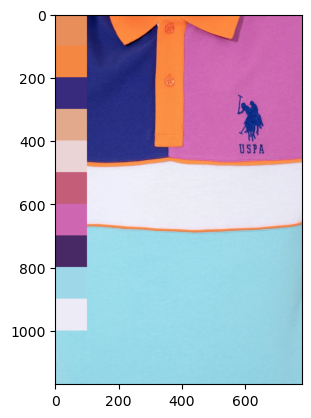

In [113]:
image = img_inRGB.copy() 
y_point = -100
for c in rgb_colors: 
    y_point += 100 
    image = cv2.rectangle(image, (0, y_point), (100, y_point + 100), color=(int(c[0]), int(c[1]),int(c[2])), thickness=-1) 

plt.imshow(image) 
plt.show()

## Calculation of Color Features 

### A: the number of pixels belonging to cluster k

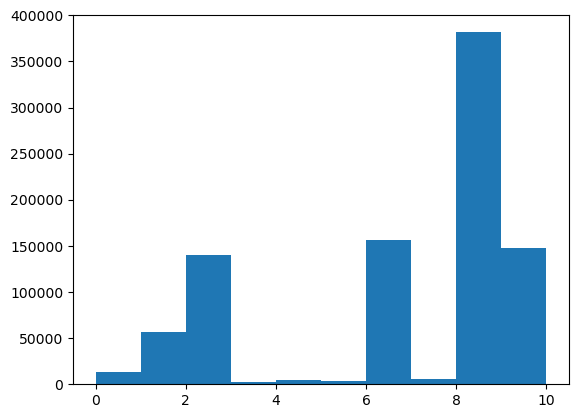

In [114]:
plt.hist(labels.ravel(), range=(0,10))
plt.show()

In [115]:
image.reshape((image.shape[0] * image.shape[1], 3)).shape 

(912600, 3)

In [116]:
Aks = [sum(labels.ravel() == label)  for label in range(10)]
max_Aks = max(Aks) 
Aks = Aks / max_Aks 
Aks 

array([0.03424352, 0.14988551, 0.36711836, 0.0062068 , 0.01308695,
       0.010501  , 0.40873459, 0.01476637, 1.        , 0.38647761])

## Saturation of a color 

- Pythagoras’ theorem

In [117]:
import math 
def calculate_saturation(lab_color: list):
    """
        - lab_color: color values in CIELAB Color space. Ex: [xx, xx, xx] = [L, a, b]
    """
    return math.sqrt(lab_color[1] ** 2 + lab_color[2] ** 2)

In [118]:
Sks = np.array([calculate_saturation(lab_color) for lab_color in centers])
max_Sk = max(Sks) 
Sks = Sks / max_Sk
Sks 

array([0.78238599, 1.        , 0.78647342, 0.45193691, 0.12532024,
       0.65428368, 0.79770883, 0.58851268, 0.32448357, 0.08062868])

## Contrast Feature 

the `calculate_contrast_lab` function takes a list of LAB color format values as input. 
It extracts the L values from each color tuple using a list comprehension.
Then, it calculates the maximum and minimum L values using `np.max` and `np.min` functions, respectively. Finally, it calculates the contrast using the formula mentioned earlier.

contrast = (L_max - L_min) / L_min

In [119]:
img_inLAB[(labels == 0).squeeze()]

sum([img_inLAB[(labels == label).squeeze()].shape[0] for label in range(10)]), img_inLAB.shape[0]

(912600, 912600)

In [120]:
def calculate_contrast_lab(lab_values):
    L_values = [color[0] for color in lab_values]
    L_max = np.max(L_values)
    L_min = np.min(L_values)

    contrast = (L_max - L_min) / L_min # TO DO: zero division error !

    return contrast

In [121]:
Cks = [calculate_contrast_lab(img_inLAB[(labels == label).squeeze()]) for label in range(10)] 
max_Ck = max(Cks) 
Cks = Cks / max_Ck
Cks

array([0.06800209, 0.02580175, 0.35247976, 0.04239467, 0.02687655,
       0.19877065, 0.04412909, 1.        , 0.01520093, 0.00713443])

## integrative color feature pk

Pks = Cks + Aks + Sks

1) Select the color k with the highest saturation Sk . 
2) Select the color k with the largest area Ak . 
3) Repeatedly select colors k based on the pk values until 5 colors are selected

In [122]:
Pks = Cks + Aks + Sks
Pks

array([0.8846316 , 1.17568726, 1.50607154, 0.50053838, 0.16528374,
       0.86355532, 1.2505725 , 1.60327905, 1.3396845 , 0.47424071])

In [123]:
candidates = pd.DataFrame({"C": Cks, "A": Aks, "S": Sks, "p": Pks}, index=[str(tuple(center)) for center in centers])

candidates

C         A         S         p
(67.95844, 31.914118, 41.770153)    0.068002  0.034244  0.782386  0.884632
(68.18086, 38.473274, 55.08166)     0.025802  0.149886  1.000000  1.175687
(22.838018, 25.414019, -46.32852)   0.352480  0.367118  0.786473  1.506072
(74.243515, 18.669287, 23.947145)   0.042395  0.006207  0.451937  0.500538
(86.79756, 8.228873, 1.7837074)     0.026877  0.013087  0.125320  0.165284
(53.24915, 43.59136, 5.679507)      0.198771  0.010501  0.654284  0.863555
(58.156445, 49.41824, -20.74583)    0.044129  0.408735  0.797709  1.250573
(23.19209, 24.842571, -30.76233)    1.000000  0.014766  0.588513  1.603279
(82.78324, -16.656115, -14.066635)  0.015201  1.000000  0.324484  1.339684
(93.462135, 2.0131338, -5.029306)   0.007134  0.386478  0.080629  0.474241

### Boundry Cluster Detection 

In [ ]:
def find_location_RGB(image_array, target_rgb): 
    result = None 
    for i in range(image_array.shape[0]):
        for j in range(image_array.shape[1]):
            pixel_rgb = image_array[i, j, :]
            if np.array_equal(pixel_rgb, target_rgb):
                result = (i, j)
    
    return result     

In [ ]:
import numpy as np

# Assuming `lab_image` is your CIELAB image array of shape (224, 224, 3)
lab_image = im.copy()  # Your CIELAB image array
x = [ 57.55410826,  48.74906298, -20.49127085]

# Iterate over the Lab image and find the pixel location
for i in range(lab_image.shape[0]):
    for j in range(lab_image.shape[1]):
        lab_pixel = lab_image[i, j]
        if np.allclose(lab_pixel, x):
            location = (i, j)
            break

print("Pixel Location:", location)


Pixel Location: (462, 582)


In [ ]:
import numpy as np

# Assuming `lab_image` is your CIELAB image array of shape (224, 224, 3)
lab_image = im.copy()  # Your CIELAB image array
x = np.array([ 79.75394908, -15.00465282, -13.95883146])
lab_image_reshaped = lab_image.reshape(-1, 3)

# Find the pixel location using vectorized operations
distances = np.linalg.norm(lab_image_reshaped - x, axis=1)
index = np.argmin(distances)

# Convert the flattened index back to pixel coordinates
location = np.unravel_index(index, lab_image.shape[:2])

print("Pixel Location:", location)


Pixel Location: (679, 8)


In [157]:
segmented_image = centers[labels.ravel()].reshape(img_inLAB_original.shape).copy()  # Your Lab image array

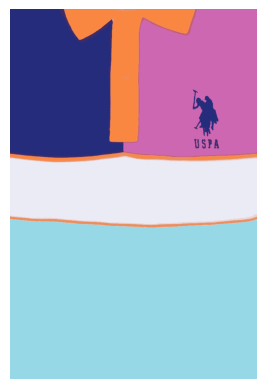

In [158]:
rgb_image = color.lab2rgb(segmented_image)
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


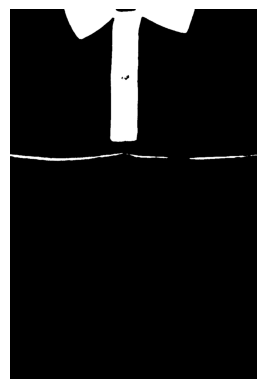

In [185]:
lab_image = segmented_image.copy()
x = np.array(centers[1])
mask = np.all(lab_image == x, axis=2)

masked_image = np.copy(lab_image)
masked_image[~mask] = 0 
masked_image[mask] = 255 

plt.imshow(masked_image)
plt.axis('off')
plt.show()